# STYLE TRANSFER USING VGG NET

In [12]:
!pip install torch
!pip install PIL
!pip install torchvision

!pip install Pillow==4.0.0
!pip install image

  Could not find a version that satisfies the requirement PIL (from versions: )
No matching distribution found for PIL
  Using cached https://files.pythonhosted.org/packages/62/94/5430ebaa83f91cc7a9f687ff5238e26164a779cca2ef9903232268b0a318/Pillow-5.3.0-cp36-cp36m-manylinux1_x86_64.whl
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
  Using cached https://files.pythonhosted.org/packages/37/e8/b3fbf87b0188d22246678f8cd61e23e31caa1769ebc06f1664e2e5fe8a17/Pillow-4.0.0-cp36-cp36m-manylinux1_x86_64.whl
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
  Found existing installation: Pillow 5.3.0
    Uninstalling Pillow-5.3.0:
      Successfully uninstalled Pillow-5.3.0


In [0]:
%matplotlib inline
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
from torchvision import transforms, models

# Load the VGG 19 pretrained network

In [6]:
# here, we only loaded the features of vgg19 and not the classifrs because we dont need that
vgg = models.vgg19(pretrained=True).features

#next, we freeze the VGG parameters or weights because we only want to optimize the target image

for param in vgg.parameters():
  param.requires_grad_(False)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.torch/models/vgg19-dcbb9e9d.pth
100%|██████████| 574673361/574673361 [00:07<00:00, 81566442.70it/s]


In [7]:
#we then move the model to gpu
isGPU = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg.to(isGPU)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

# Load in Content and Style Images

In [0]:
def load_image(img_path, max_size=400, shape=None):
  '''Load in and transform an image, making sure 
  the image is <=400 pixels in the x - y dims.'''
  
  image = Image.open(img_path).convert('RGB')
  
  # note, large images will slow down processing 
  if max(image.size) > max_size:
    size = max_size
  else:
    size = max(image.size)
    
  if shape is not None:
    size = shape
      
  in_transform = transforms.Compose([
      transforms.Resize(size),
      transforms.ToTensor(),
      transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))])
  
  # discard the transparent, alpha channel (that's the :3)
  
  image = in_transform(image)[:3,:,:].unsqueeze(0)
  
  return image
    

the next step is to load the images by file name

In [0]:
#load th content an style image

content = load_image('keneeng.jpg').to(isGPU)

#Resize style to match content, makes cose easier

style = load_image('monalisa.jpg', shape=content.shape[-2:]).to(isGPU)

In [0]:
# helper function that converts a normalized image to am unnormalized image for display (ie numpy image)
# ie coverting a tensor image to a numpy image

def im_convert(tensor):
  """Display a tensor as an image. """
  
  image = tensor.to("cpu").clone().detach()
  image = image.numpy().squeeze()
  image = image.transpose(1,2,0)
  image = image * np.array((0.229, 0.224, 0.225)) +np.array((0.485, 0.456, 0.406))
  image = image.clip(0, 1)
  
  return image

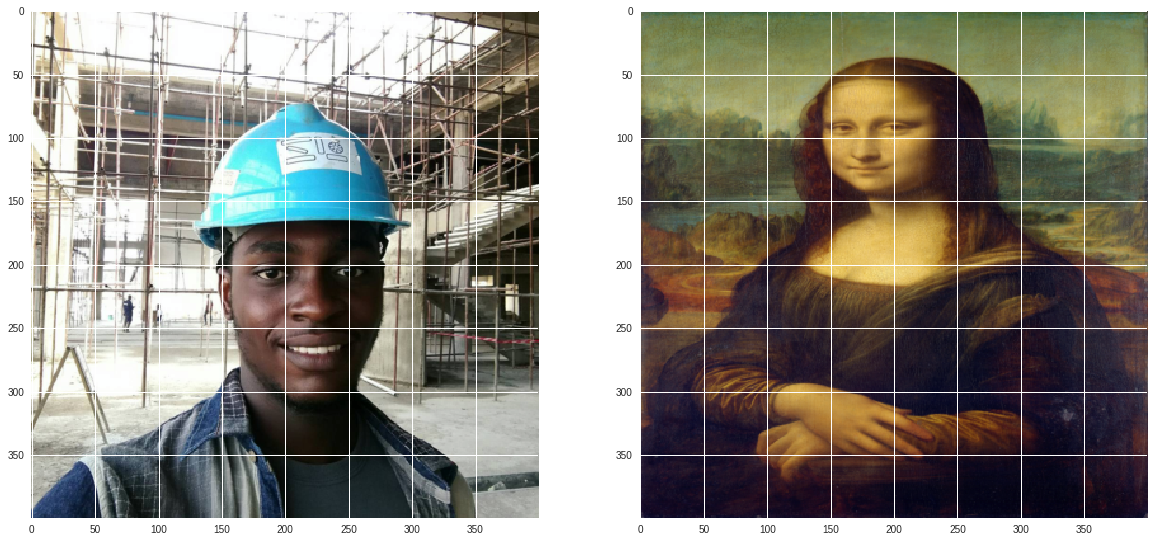

In [53]:
# lets display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

#content and style imag side by side
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))


# VGG19 LAYERS

In [0]:
def get_features(image, model, layers=None):
    """ Run an image forward through a model and get the features for 
        a set of layers. Default layers are for VGGNet matching Gatys et al (2016)
    """
    
    ## TODO: Complete mapping layer names of PyTorch's VGGNet to names from the paper
    ## Need the layers for the content and style representations of an image
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',  ## content representation
                  '28': 'conv5_1'}
        
    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

In [0]:
# the gram matrix
def gram_matrix(tensor):
    """ Calculate the Gram Matrix of a given tensor 
        Gram Matrix: https://en.wikipedia.org/wiki/Gramian_matrix
    """
    
    # get the batch_size, depth, height, and width of the Tensor
    _, d, h, w = tensor.size()
    
    # reshape so we're multiplying the features for each channel
    tensor = tensor.view(d, h * w)
    
    # calculate the gram matrix
    gram = torch.mm(tensor, tensor.t())
    
    return gram

# Putting it all together

In [0]:
# get content and style features only once before training
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# calculate the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# create a third "target" image and prep it for change
# it is a good idea to start of with the target as a copy of our *content* image
# then iteratively change its style
target = content.clone().requires_grad_(True).to(isGPU)

# Loss and weight

In [0]:
# weights for each style layer 
# weighting earlier layers more will result in *larger* style artifacts
# notice we are excluding `conv4_2` our content representation
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.85,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1  # alpha
style_weight = 1e4  # beta

# Updating and calculating the loss

Total loss:  219021.546875


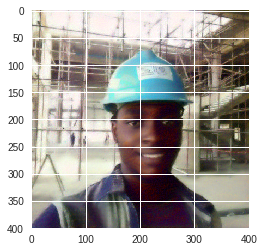

Total loss:  97223.0859375


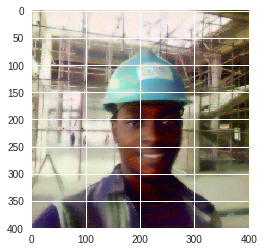

Total loss:  59537.19140625


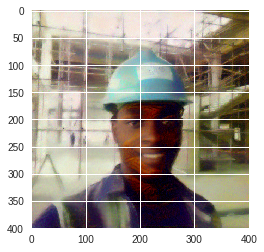

Total loss:  41155.36328125


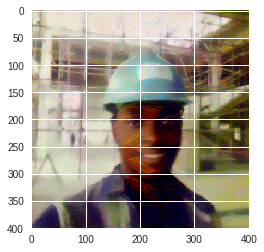

Total loss:  30504.1328125


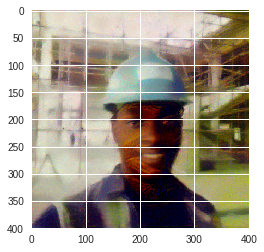

In [58]:

# for displaying the target image, intermittently
show_every = 400

# iteration hyperparameters
optimizer = optim.Adam([target], lr=0.003)
steps = 2000  # decide how many iterations to update your image (5000)

for ii in range(1, steps+1):
    
    # get the features from your target image
    target_features = get_features(target, vgg)
    
    # the content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    # the style loss
    # initialize the style loss to 0
    style_loss = 0
    # then add to it for each layer's gram matrix loss
    for layer in style_weights:
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        # get the "style" style representation
        style_gram = style_grams[layer]
        # the style loss for one layer, weighted appropriately
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        # add to the style loss
        style_loss += layer_style_loss / (d * h * w)
        
    # calculate the *total* loss
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # display intermediate images and print the loss
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

# Displaying the target image

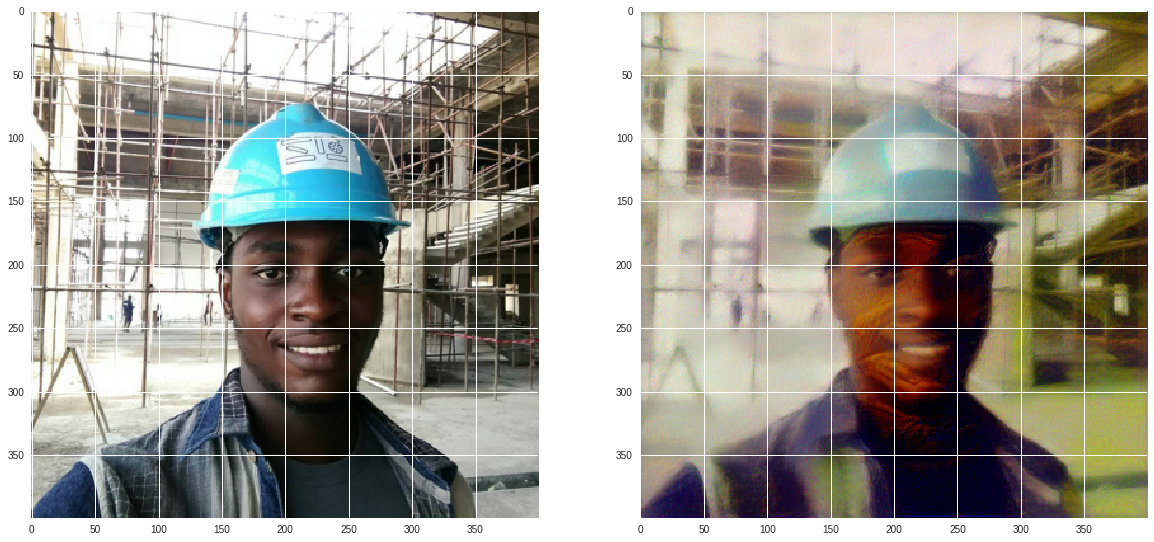

In [59]:

# display content and final, target image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))

In [24]:
!wget "https://github.com/udacity/deep-learning-v2-pytorch/raw/master/style-transfer/Style_Transfer_Solution.ipynb"

--2018-12-23 10:28:15--  https://github.com/udacity/deep-learning-v2-pytorch/raw/master/style-transfer/Style_Transfer_Solution.ipynb
Resolving github.com (github.com)... 192.30.253.113, 192.30.253.112
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/style-transfer/Style_Transfer_Solution.ipynb [following]
--2018-12-23 10:28:16--  https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/style-transfer/Style_Transfer_Solution.ipynb
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3285866 (3.1M) [text/plain]
Saving to: ‘Style_Transfer_Solution.ipynb’

Style_Transfer_Solu 100%[===================>